## Import all what we need.

In [1]:
# encoding: utf-8
import os
import bz2
import csv
import glob
import time
import requests
import numpy as np
import numexpr as ne
import pandas as pd
from tqdm import tqdm
from numba import njit
from io import StringIO
import astropy.units as au
import matplotlib.pyplot as plt
import threading, multiprocessing
from scipy.special import voigt_profile, wofz, erf

## The Input File Path


<table><tr><td bgcolor=skyblue><font size=24> Could be changed ! </font></td></tr></table>

In [2]:
#########################################################
inp_filepath = '/home/jingxin/PyExoCross-ing/input/MgH_exomol.inp'
#########################################################

## Report time

In [3]:
class Timer:    
    def start(self):
        self.start_CPU = time.process_time()
        self.start_sys = time.time()
        return self

    def end(self, *args):
        self.end_CPU = time.process_time()
        self.end_sys = time.time()
        self.interval_CPU = self.end_CPU - self.start_CPU
        self.interval_sys = self.end_sys - self.start_sys
        print('{:25s} : {}'.format('Running time on CPU', self.interval_CPU), 's')
        print('{:25s} : {}'.format('Running time on system', self.interval_sys), 's')

## Read Information from Input File

In [4]:
def inp_para(inp_filepath):
    
    inp_col_name = ['c0','c1','c2','c3','c4','c5']
    inp_df = pd.read_csv(inp_filepath, sep='\\s+', names=inp_col_name, usecols=[0,1,2,3,4,5], header=None)
    col0 = inp_df['c0']
    
    # Database
    database = inp_df[col0.isin(['Database'])]['c1'].values[0]
    
    # Basic information
    molecule = inp_df[col0.isin(['Molecule'])]['c1'].values[0]
    isotopologue = inp_df[col0.isin(['Isotopologue'])]['c1'].values
    dataset = inp_df[col0.isin(['Dataset'])]['c1'].values
    mol_iso_id = int(inp_df[col0.isin(['mol_iso_id'])]['c1'])
    
    # File path
    read_path = inp_df[col0.isin(['ReadPath'])]['c1'].values[0]
    save_path = inp_df[col0.isin(['SavePath'])]['c1'].values[0]
    if os.path.exists(save_path):
        pass
    else:
        os.makedirs(save_path, exist_ok=True)
        
    # Functions 
    PartitionFunctions = int(inp_df[col0.isin(['PartitionFunctions'])]['c1'])
    CoolingFunctions = int(inp_df[col0.isin(['CoolingFunctions'])]['c1'])
    Lifetimes = int(inp_df[col0.isin(['Lifetimes'])]['c1'])
    SpecificHeats = int(inp_df[col0.isin(['SpecificHeats'])]['c1'])
    CrossSections = int(inp_df[col0.isin(['CrossSections'])]['c1'])
    
    # Calculate partition, cooling functions or specific heats 
    Ntemp = int(inp_df[col0.isin(['Ntemp'])]['c1'])    # The number of temperature steps
    Tmax = int(inp_df[col0.isin(['Tmax'])]['c1'])      # Maximal temperature in K (minimal T = 1 K )
     
     
    # Calculate lifetimes 
    # None
    

    # Calculate cross-sections 
    broadeners = list(inp_df[col0.isin(['Broadeners'])].iloc[0])[1:]
    ratios = np.array(list(inp_df[col0.isin(['Ratios'])].iloc[0])[1:], dtype=float)
    
    T = int(inp_df[col0.isin(['Temperature'])]['c1'])
    P = float(inp_df[col0.isin(['Pressure'])]['c1'])
    min_wn = float(inp_df[col0.isin(['Range'])]['c1'])
    max_wn = float(inp_df[col0.isin(['Range'])]['c2'])
    NpointsORBinSize = inp_df[col0.isin(['Npoints/BinSize'])]['c1'].values[0]
    if NpointsORBinSize in ['Npoints', 'Npoint', 'NPoints', 'NPoint', 'npoints', 'npoint']:
        N_point = int(inp_df[col0.isin(['Npoints/BinSize'])]['c2'])
        bin_size = float((max_wn - min_wn)/(N_point-1))
    elif NpointsORBinSize in ['BinSize', 'Binsize', 'binsize', 'binSize', 'bin', 'size', 'Bin', 'Size']:
        bin_size = float(inp_df[col0.isin(['Npoints/BinSize'])]['c2'])
        N_point = int((max_wn - min_wn)/bin_size+1)
    else:
        raise ImportError("Please type the correct grid choice 'Npoints' or 'BinSize' into the input file.")
        
    wn_grid = np.linspace(min_wn, max_wn, N_point)
    
    # cutoffYN = float(inp_df[col0.isin(['Cutoff'])]['c1'])
    cutoffYN = inp_df[col0.isin(['Cutoff(Y/N)'])]['c1'].values[0]
    if cutoffYN in ['Y', 'Yes', 'yes', 'YES']:
        cutoff = float(inp_df[col0.isin(['Cutoff(Y/N)'])]['c2'])
    elif cutoffYN in ['N', 'No', 'no', 'NO']:
        cutoff = 'None'
    else:
        raise ImportError("Please type the correct cutoff choice 'Y' or 'N' into the input file.")
    
    # thresholdYN = float(inp_df[col0.isin(['Threshold'])]['c1'])
    thresholdYN = inp_df[col0.isin(['Threshold(Y/N)'])]['c1'].values[0]
    if thresholdYN in ['Y', 'Yes', 'yes', 'YES']:
        threshold = float(inp_df[col0.isin(['Threshold(Y/N)'])]['c2'])
    elif thresholdYN in ['N', 'No', 'no', 'NO']:
        threshold = 'None'
    else:
        raise ImportError("Please type the correct threshold choice 'Y' or 'N' into the input file.")
    
    UncFilterYN = inp_df[col0.isin(['UncFilter(Y/N)'])]['c1'].values[0]
    if UncFilterYN in ['Y', 'Yes', 'yes', 'YES']:
        UncFilter = float(inp_df[col0.isin(['UncFilter(Y/N)'])]['c2'])
    elif UncFilterYN in ['N', 'No', 'no', 'NO']:
        UncFilter = 'None'
    else:
        raise ImportError("Please type the correct uncertainty filter choice 'Y' or 'N' into the input file.")
    
    abs_emi = inp_df[col0.isin(['Absorption/Emission'])]['c1'].values[0]
    profile = inp_df[col0.isin(['Profile'])]['c1'].values[0]
    wn_wl = inp_df[col0.isin(['Wavenumber(wn)/wavelength(wl)'])]['c1'].values[0]
    

    molecule_id = int(mol_iso_id/10)
    isotopologue_id = mol_iso_id - molecule_id * 10
        
    if database == 'ExoMol':
        # Read ExoMol definition file (.def) to get the mass.
        deffile_path = (read_path+'/'+molecule+'/'+isotopologue+'/'+dataset+'/'+isotopologue+'__'+dataset+'.def')
        def_df = pd.read_csv(deffile_path[0],sep='\\s+',usecols=[0,1,2,3,4],names=['0','1','2','3','4'],header=None)
        abundance = 1
        mass = float(def_df[def_df['4'].isin(['mass'])]['0'].values[0])     # ExoMol mass (Dalton)
        check_uncertainty = int(def_df[def_df['2'].isin(['Uncertainty'])]['0'].values[0])
        check_lifetime = int(def_df[def_df['2'].isin(['Lifetime'])]['0'].values[0])
    elif database == 'HITRAN':
        isometa_url = 'https://hitran.org/docs/iso-meta/'
        iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
        iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
        abundance = float(iso_meta_row['Abundance'][0].replace('\xa0×\xa010','E'))
        mass = float(iso_meta_row['Molar Mass /g·mol-1'])                   # HITRAN molar mass (g/mol)
        check_uncertainty = 0
        check_lifetime = 0
    else:
        raise ImportError("Please add the name of the database 'ExoMol' or 'HITRAN' into the input file.")
    

    return (database, molecule, isotopologue, dataset, read_path, save_path, 
            PartitionFunctions, CoolingFunctions, Lifetimes, SpecificHeats, CrossSections,
            Ntemp, Tmax, broadeners, ratios, T, P, min_wn, max_wn, N_point, bin_size, wn_grid, 
            cutoff, threshold, UncFilter, abs_emi, profile, wn_wl, 
            molecule_id, isotopologue_id, abundance, mass, check_uncertainty, check_lifetime)


## Constants and Parameters

In [7]:
# Parameters for calculating
import astropy.constants as ac
#from astropy import constants, units as ac, au
Tref = 296.0                        # Reference temperature is 296 K
Pref = 1.0                          # Reference pressure is 1 bar
N_A = ac.N_A.value                  # Avogadro number (1/mol)
h = ac.h.to('erg s').value          # Planck's const (erg s)
c = ac.c.to('cm/s').value           # Velocity of light (cm/s)
kB = ac.k_B.to('erg/K').value       # Boltzmann's const (erg/K)
R = ac.R.to('J / (K mol)').value    # Molar gas constant (J/(K mol))
c2 = h * c / kB                     # Second radiation constant (cm K)

(database, molecule, isotopologue, dataset, read_path, save_path, 
 PartitionFunctions, CoolingFunctions, Lifetimes, SpecificHeats, CrossSections,
 Ntemp, Tmax, broadeners, ratios, T, P, min_wn, max_wn, N_point, bin_size, wn_grid, 
 cutoff, threshold, UncFilter, abs_emi, profile, wn_wl, 
 molecule_id, isotopologue_id, abundance, mass, 
 check_uncertainty, check_lifetime) = inp_para(inp_filepath)

# c2InvT = c2 / T                     # c2 / T (cm)
c2InvTref = c2 / Tref                 # c2 / T_ref (cm)
PI = np.pi
sinPI = np.sin(np.pi)
SqrtPI = np.sqrt(np.pi)
Sqrtln2 = np.sqrt(np.log(2))
OneminSqrtPIln2 = 1 - np.sqrt(np.pi * np.log(2))
Negln2 = -np.log(2)
Inv8Pic = 1 / (8 * np.pi * c)         # 8 * pi * c (s/cm)
Inv4Pi = 1 / (4 * np.pi)
InvSqrt2 = 1 / np.sqrt(2)
InvSqrt2Pi = 1 / np.sqrt(2 * np.pi)
InvSqrt2ln2 = 1 / np.sqrt(2 * np.log(2))
TwoSqrt2ln2 = 2 * np.sqrt(2 * np.log(2))
Sqrtln2InvPi = np.sqrt(np.log(2) / np.pi)
Sqrt2NAkBln2mInvc = np.sqrt(2 * N_A * kB * np.log(2) / mass) / c
# Sqrt2NAkBln2mInvc = np.sqrt(2 * kB * np.log(2) / (mass*au.u.to(au.g))) / c
# TrefInvT = Tref / T
# PInvPref = P / Pref

# Read Input Files

Read the parameters of the linelist in ExoMol or HITRAN format text file. Return the dataframe of the data for the following calculations.

## Read ExoMol Database Files

### Read States File

In [7]:
def read_all_states(read_path):
    
    s_df = dict()
    states_df = pd.DataFrame()
    states_filenames = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset 
                                  + '/' + isotopologue + '__' + dataset + '.states.bz2')[0])

    for states_filename in states_filenames:
        s_df[states_filename] = pd.read_csv(states_filename, compression='bz2', sep='\s+', header=None,
                                            chunksize=100000, iterator=True, low_memory=False, dtype=object)
        for chunk in s_df[states_filename]:
            states_df = pd.concat([states_df, chunk])
            
    pd.set_option("display.max_columns",30)                           
    return(states_df)

In [8]:
#states_df = read_all_states(read_path)
#states_df 

### Read transitions File

In [9]:
def get_transfiles(read_path):
    # Get all the transitions files from the folder including the older version files which are named by vn(version number).
    trans_filepaths_all = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')[0])
    num_transfiles_all = len(trans_filepaths_all)    # The number of all transitions files including the older version files.
    trans_filepaths = []    # The list of the lastest transitions files.
    for i in range(num_transfiles_all):
        split_version = trans_filepaths_all[i].split('__')[-1].split('.')[0].split('_')    # Split the filenames.
        num = len(split_version)
        # There are four format filenames.
        # The lastest transitions files named in two formats:
        # 1. Filenames are named with the name of isotopologue and dataset. 
        #    End with .trans.bz2.
        #    e.g. 14N-16O__XABC.trans.bz2'
        # 2. Filenames are named with the name of isotopologue and dataset. 
        #    Also have the range of wavenumbers xxxxx-yyyyy.
        #    End with .trans.bz2.
        #    e.g. 1H2-16O__POKAZATEL__00000-00100.trans.bz2
        # 3. The older version transitions files are named with vn(version number) based on the first format of the lastest files.
        #    e.g. 14N-16O__XABC_v2.trans.bz2
        # 4. The older version transitions files are named with updated date (yyyymmdd).
        #    e.g. 1H3_p__MiZATeP__20170330.trans.bz2
        # After split the filenames:
        # The first format filenames only leave the dataset name, e.g. XABC.
        # The second format filenames only leave the range of the wavenumber, e.g. 00000-00100.
        # The third format filenames leave two parts(dataset name and version number), e.g. XABC and v2.
        # The fourth format filenames only leave the updated date, e.g. 20170330.
        # This program only process the lastest data, so extract the filenames named by the first two format.
        if num == 1:     
            if split_version[0] == dataset:        
                trans_filepaths.append(trans_filepaths_all[i])
            if len(split_version[0].split('-')) == 2:
                trans_filepaths.append(trans_filepaths_all[i])
    return(trans_filepaths)    

In [10]:
def read_all_trans(read_path):
    
    t_df = dict()
    trans_df = pd.DataFrame()
    trans_col_name = ['u', 'l', 'A', 'v']
    trans_filepaths = get_transfiles(read_path)

    for trans_filename in tqdm(trans_filepaths):
        t_df[trans_filename] = pd.read_csv(trans_filename, compression='bz2', sep='\s+', header=None,
                                           names=trans_col_name, chunksize=100000, iterator=True, low_memory=False)
        for chunk in t_df[trans_filename]:
            trans_df = pd.concat([trans_df,chunk])
            
    #pd.set_option("display.max_columns",30)                           
    return(trans_df)
    

In [11]:
#all_trans_df = read_all_trans(read_path)
#all_trans_df

## Convert among the frequency, upper and lower state energy

In [12]:
@njit(parallel=True, fastmath=True)
def cal_v(Epp, Ep):
    v = np.abs(Epp - Ep)
    return(v)

In [13]:
@njit(parallel=True, fastmath=True)
def cal_Ep(Epp, v):
    Ep = np.abs(Epp + v)
    return(Ep)

### Read Partition Function File From ExoMol Database

In [14]:
def read_exomolweb_pf(T):
    
    pf_url = ('http://www.exomol.com/db/' + molecule + '/' + isotopologue + '/' + dataset 
              + '/' + isotopologue + '__' + dataset + '.pf')[0]
    pf_content = requests.get(pf_url).text
    pf_col_name = ['T', 'Q']
    pf_df = pd.read_csv(StringIO(pf_content), sep='\\s+', names=pf_col_name, header=None)
    Q = pf_df['Q'][T-1]

    return(Q)

In [15]:
def read_exomol_pf(read_path, T):
    
    pf_filename = (read_path + molecule + '/' + isotopologue + '/' + dataset 
                   + '/' + isotopologue + '__' + dataset + '.pf')[0]
    pf_col_name = ['T', 'Q']
    pf_df = pd.read_csv(pf_filename, sep='\\s+', names=pf_col_name, header=None)
    Q = pf_df['Q'][T-1]

    return(Q)

### Read Broadening File

In [16]:
def read_broad(read_path):
    broad_col_name = ['code', 'gamma_L', 'n_air', 'Jpp']
    broad_path = (read_path + molecule + '/' + isotopologue + '/' + isotopologue + '__air.broad')[0]
    if not os.path.exists(broad_path):
        raise ImportError('The boradening file ' + broad_path + ' does not exist.')
    broad_df = pd.read_csv(broad_path, sep='\s+', names=broad_col_name, header=None, engine='python')
    return(broad_df)

In [17]:
def read_broad(read_path):
    broad_col_name = ['code', 'gamma_L', 'n_air', 'Jpp']

    default_broad_df = pd.DataFrame(columns=broad_col_name)
    air_broad_df = pd.DataFrame(columns=broad_col_name)
    self_broad_df = pd.DataFrame(columns=broad_col_name)
    H2_broad_df = pd.DataFrame(columns=broad_col_name)
    He_broad_df = pd.DataFrame(columns=broad_col_name)

    broad = []
    ratio = []
    for i in range(len(ratios)):
        if ratios[i] != 0.0:
            if broadeners[i] == 'Default':
                default_gamma_L = 0.07
                default_n_air = 0.5
                #default_gamma_L = 1
                #default_n_air = 0.01
                default_broad_df = pd.DataFrame([['code', default_gamma_L, default_n_air,'Jpp']],columns=broad_col_name)
            if broadeners[i] == 'Air':
                broad_path = (read_path + molecule + '/' + isotopologue + '/' + isotopologue + '__air.broad')[0]
                if not os.path.exists(broad_path):
                    raise ImportError('The boradening file ' + broad_path + ' does not exist.')    
                air_broad_df = pd.read_csv(broad_path, sep='\s+', names=broad_col_name, header=None, engine='python')
            if broadeners[i] == 'Self':
                broad_path = (read_path + molecule + '/' + isotopologue + '/' + isotopologue + '__self.broad')[0]
                if not os.path.exists(broad_path):
                    raise ImportError('The boradening file ' + broad_path + ' does not exist.')    
                self_broad_df = pd.read_csv(broad_path, sep='\s+', names=broad_col_name, header=None, engine='python')
            if broadeners[i] == 'H2':
                broad_path = (read_path + molecule + '/' + isotopologue + '/' + isotopologue + '__H2.broad')[0]
                if not os.path.exists(broad_path):
                    raise ImportError('The boradening file ' + broad_path + ' does not exist.')    
                H2_broad_df = pd.read_csv(broad_path, sep='\s+', names=broad_col_name, header=None, engine='python')
            if broadeners[i] == 'He':
                broad_path = (read_path + molecule + '/' + isotopologue + '/' + isotopologue + '__He.broad')[0]
                if not os.path.exists(broad_path):
                    raise ImportError('The boradening file ' + broad_path + ' does not exist.')    
                He_broad_df = pd.read_csv(broad_path, sep='\s+', names=broad_col_name, header=None, engine='python')
            
            broad.append(broadeners[i])
            ratio.append(ratios[i])
    print('Broadeners \t: ', broadeners[0],'\t',broadeners[1],'\t',broadeners[2],'\t',broadeners[3],'\t',broadeners[4])
    print('Ratios \t\t: ', ratios[0],'\t\t',ratios[1],'\t',ratios[2],'\t',ratios[3],'\t',ratios[4])
    return(broad,ratio,default_broad_df,air_broad_df,self_broad_df,H2_broad_df,He_broad_df)        


## Read HITRAN Database Files

### Read HITRAN Linelist File

In [18]:
def read_hitran_parfile (read_path, parfile_df):
    '''
    Read the parameters of the molecular absorption features
    of HITRAN2020 format text file.
    
    Parameters
    ----------
    par_filepath : str
        Input file path for reading.
    Return
    ------
    hitran_df : DataFrame
        The DataFrame of HITRAN data for the molecule.
    '''    
    par_filename = read_path.split('/')[-1]
    if (len(str(parfile_df[0][0])) < 160):
        raise ImportError('The file ' + par_filename + ' is not a HITRAN2020 format data file.')
    #hitran_column_name = ['M','I','v','S','Acoeff','gamma_air','gamma_self',
    #                     'Epp','n_air','delta_air','Vp','Vpp','Qp','Qpp',
    #                     'Ierr','Iref','flag','gp','gpp']

    hitran_df = pd.DataFrame()
    hitran_df['M'] = pd.to_numeric(parfile_df[0].map(lambda x: x[0:2]), errors='coerce').astype('int32')                 # Molecule identification number
    hitran_df['I'] = pd.to_numeric(parfile_df[0].map(lambda x: x[2:3]), errors='coerce').astype('int32')                 # Isotopologue number
    hitran_df['v'] = pd.to_numeric(parfile_df[0].map(lambda x: x[3:15]), errors='coerce').astype('float64')              # Transition wavenumber (in cm^{-1})
    hitran_df['S'] = pd.to_numeric(parfile_df[0].map(lambda x: x[15:25]), errors='coerce').astype('float64')             # Intensity (cm^{-1} / (molecule cm^{-2}))
    hitran_df['A'] = pd.to_numeric(parfile_df[0].map(lambda x: x[25:35]), errors='coerce').astype('float64')             # The Einstein-A coefficient (s^{-1}) of a transition
    hitran_df['gamma_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[35:40]), errors='coerce').astype('float64')     # Air-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['gamma_self'] = pd.to_numeric(parfile_df[0].map(lambda x: x[40:45]), errors='coerce').astype('float64')    # Self-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['Epp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[45:55]), errors='coerce').astype('float64')           # Lower state energy (cm^{-1})
    hitran_df['n_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[55:59]), errors='coerce').astype('float64')         # Temperature-dependent exponent for gamma_air
    hitran_df['delta_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[59:67]), errors='coerce').astype('float64')     # Air pressure_include line shift (cm^{-1} atm^{-1})
    #hitran_df['Vp'] = parfile_df[0].map(lambda x: x[67:82])                                                              # Upper-state "global" quanta
    #hitran_df['Vpp'] = parfile_df[0].map(lambda x: x[82:97])                                                             # Lower-state "global" quanta
    #hitran_df['Qp'] = parfile_df[0].map(lambda x: x[97:112])                                                             # Upper-state "local" quanta
    #hitran_df['Qpp'] = parfile_df[0].map(lambda x: x[112:127])                                                           # Lower-state "local" quanta
    hitran_df['gp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[146:153]), errors='coerce').astype('float64')          # Statistical weight of the upper state
    
    hitran_df = hitran_df[hitran_df['M'].isin([molecule_id])]
    hitran_df = hitran_df[hitran_df['I'].isin([isotopologue_id])]
    hitran_df = hitran_df[hitran_df['v'].between(min_wn, max_wn)]
    if threshold != 'None':
        hitran_df = hitran_df[hitran_df['S'] >= threshold]
    
    return hitran_df


In [19]:
def read_parfile(read_path):
    if not os.path.exists(read_path):
        raise ImportError('The input file ' + read_path + ' does not exist.')

    # Initialise the iterator object.
    read_par = pd.read_csv(read_path, chunksize=10000, iterator=True, header=None, encoding='utf-8')
    par_df = pd.DataFrame()
    for chunk in read_par:
        par_df = pd.concat([par_df, chunk])
    return(par_df)

### Read Partition Function File From HITRANOnline

In [20]:
def read_hitran_pf(T):
    isometa_url = 'https://hitran.org/docs/iso-meta/'
    iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
    iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
    #Q_ref = float(iso_meta_row.loc[0][6].replace('\xa0×\xa010','E'))
    Q_url = 'https://hitran.org/data/Q/' + iso_meta_row.loc[0][7]
    Q_content = requests.get(Q_url).text
    Q_col_name = ['T', 'Q']
    Q_df = pd.read_csv(StringIO(Q_content), sep='\\s+', names=Q_col_name, header=None)
    Q = Q_df['Q'][T - 1]   
    return(Q)

# Calculate Parition Function


In [21]:
@njit(parallel=True, fastmath=True)
def calculate_partition(En, gn, T):
    partition_func = np.sum(gn * np.exp(-c2 * En / T))
    return(partition_func)

In [22]:
# Partition function
def exomol_partition_func(read_path, states_df, Ntemp, Tmax):
    
    print('Calculate partition functions.')  
    t = Timer()
    t.start()
    
    #states_df = read_all_states(read_path)
    En = states_df[1].astype('float').values
    gn = states_df[2].astype('int').values
    Ts = np.array(range(Ntemp, Tmax+1, Ntemp)) 
    
    partition_func = [calculate_partition(En, gn, T) for T in Ts]
    
    partition_func_df = pd.DataFrame()
    partition_func_df['T'] = Ts
    partition_func_df['partition function'] = partition_func
        
    pf_folder = save_path + '/partition/'
    if os.path.exists(pf_folder):
        pass
    else:
        os.makedirs(pf_folder, exist_ok=True)
    pf_path = (pf_folder + isotopologue + '__' + dataset + '.pf')[0]
    np.savetxt(pf_path, partition_func_df, fmt="%8.1f %15.4f")
    
    t.end()
    print('Partition functions has been saved!\n')  


In [23]:
#Ntemp = 1
#Tmax = int(5000.00)

#exomol_partition_func(read_path, states_df, Ntemp, Tmax)

# Specific Heat

In [24]:
@njit(parallel=True, fastmath=True)
def calculate_specific_heats(En, gn, T):
    pf = np.sum(gn * np.exp(-c2 * En / T))  
    pfp = np.sum(gn * np.exp(-c2 * En / T) * (c2 * En / T))
    pfpp = np.sum(gn * np.exp(-c2 * En / T) * (c2 * En / T) ** 2)
    specificheat_func = R * (pfpp / pf - (pfp / pf)**2) + 2.5 * R
    return(specificheat_func)

In [25]:
# Specific heat
def exomol_specificheat(read_path, states_df, Ntemp, Tmax):
    print('Calculate specific heats.')  
    t = Timer()
    t.start()
    
    #states_df = read_all_states(read_path)
    En = states_df[1].astype('float').values
    gn = states_df[2].astype('int').values
    Ts = np.array(range(Ntemp, Tmax+1, Ntemp)) 
    
    specificheat_func = [calculate_specific_heats(En, gn, T) for T in Ts]
    
    specificheat_func_df = pd.DataFrame()
    specificheat_func_df['T'] = Ts
    specificheat_func_df['specific heat'] = specificheat_func
        
    cp_folder = save_path + '/specific_heat/'
    if os.path.exists(cp_folder):
        pass
    else:
        os.makedirs(cp_folder, exist_ok=True)  
    cp_path = (cp_folder + isotopologue + '__' + dataset + '.cp')[0]
    np.savetxt(cp_path, specificheat_func_df, fmt="%8.1f %15.4f")

    t.end()
    print('Specific heats has been saved!\n')  


In [26]:
#Ntemp = 1
#Tmax = int(5000.0)

#exomol_specificheat(read_path, states_df, Ntemp, Tmax)


# Lifetime

In [27]:
# Lifetime
def exomol_lifetime(read_path, states_df, all_trans_df):
    
    print('Calculate lifetimes.')  
    t = Timer()
    t.start()
    
    #states_df = read_all_states(read_path)
    #all_trans_df = read_all_trans(read_path)
    sum_A = all_trans_df.groupby('u')['A'].sum()
    lifetime = 1 / sum_A
    lt_df = lifetime.map('{: >12.4E}'.format).reset_index()
    lt_df.columns=['u','lt']
    uid = lt_df['u']
    add_u = pd.DataFrame()
    add_u['u'] = pd.concat([states_df[0].astype('int'), uid]).drop_duplicates(keep=False)
    add_u['lt'] = '         inf'
    lifetime_df = pd.concat([lt_df, add_u], ignore_index=True)
    lifetime_df.sort_values('u',inplace=True)
    
    states_filenames = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset 
                                  + '/' + isotopologue + '__' + dataset + '.states.bz2')[0])
    s_df = pd.read_csv(states_filenames[0], compression='bz2', header=None, dtype=object)
    lifetime_list = list(lifetime_df['lt'])
    nrows = len(s_df)
    new_rows = []
    if check_uncertainty == 0:
        for i in range(nrows):
            new_rows.append(s_df[0][i][:41]+lifetime_list[i]+s_df[0][i][53:]+'\n')
    if check_uncertainty == 1:
        for i in range(nrows):
            new_rows.append(s_df[0][i][:53]+lifetime_list[i]+s_df[0][i][65:]+'\n')

    lf_folder = save_path + '/lifetime/'
    if os.path.exists(lf_folder):
        pass
    else:
        os.makedirs(lf_folder, exist_ok=True)  
        
    ##### bz2 #####
    '''
    lf_path = (lf_folder + isotopologue + '__' + dataset + '.states.bz2')[0]

    with bz2.open(lf_path, 'wt') as f:
        for i in range(nrows):
            f.write(new_rows[i])
        f.close'''
    ###############
    
    ##### states #####
    lf_path = (lf_folder + isotopologue + '__' + dataset + '.states')[0]

    with open(lf_path, 'wt') as f:
        for i in range(nrows):
            f.write(new_rows[i])
        f.close
    ##################

    t.end()
    print('Lifetimes has been saved!\n')   


In [27]:
#exomol_lifetime(read_path, states_df, all_trans_df)

# Calculate Cooling Function

In [28]:
def linelist_coolingfunc(read_path, states_df, all_trans_df):
    #states_df = read_all_states(read_path)
    #all_trans_df = read_all_trans(read_path)
    id_u = all_trans_df['u'].values
    id_l = all_trans_df['l'].values
    states_df[0] = pd.to_numeric(states_df[0])
    states_df.set_index([0], inplace=True, drop=False)
    id_s = states_df[0]
    all_trans_df.set_index(['u'], inplace=True, drop=False)
    id_us = list(set(id_u).intersection(set(id_s)))
    trans_us_df = all_trans_df.loc[id_us]
    id_l = trans_us_df['l'].values
    id_ls = list(set(id_l).intersection(set(id_s)))
    trans_us_df.set_index(['l'], inplace=True, drop=False)
    trans_s_df = trans_us_df.loc[id_ls]
    id_su = trans_s_df['u'].values
    id_sl = trans_s_df['l'].values
    states_u_df = states_df.loc[id_su]
    states_l_df = states_df.loc[id_sl]

    Ep = states_u_df[1].values.astype('float')
    gp = states_u_df[2].values.astype('int')
    A = trans_s_df['A'].values.astype('float')

    if pd.isna(all_trans_df['v']).iloc[0] == False:
        v = trans_s_df['v'].values.astype('float')
    else:
        Epp = states_l_df[1].astype('float') # Upper state energy
        v = cal_v(Ep, Epp) 
    return (A, v, Ep, gp)

In [29]:
@njit(parallel=True, fastmath=True)
def calculate_cooling(A, v, Ep, gp, T, Q):
    cooling_func = np.sum(A * h * c * v * gp * np.exp(-c2 * Ep / T)) / (4 * np.pi * Q) * 1e7
    return(cooling_func)

In [30]:
# Cooling function
def exomol_cooling_func(read_path, states_df, all_trans_df, Ntemp, Tmax):
    
    print('Calculate cooling functions.')  
    t = Timer()
    t.start()
    
    A, v, Ep, gp = linelist_coolingfunc(read_path, states_df, all_trans_df)
    Ts = np.array(range(Ntemp, Tmax+1, Ntemp)) 
    Qs = [read_exomol_pf(read_path, T) for T in Ts]
    
    cooling_func = [calculate_cooling(A, v, Ep, gp, T, Q) for T,Q in zip(Ts,Qs)]
    
    cooling_func_df = pd.DataFrame()
    cooling_func_df['T'] = Ts
    cooling_func_df['cooling function'] = cooling_func

    cf_folder = save_path + '/cooling/'
    if os.path.exists(cf_folder):
        pass
    else:
        os.makedirs(cf_folder, exist_ok=True)  
    cf_path = (cf_folder + isotopologue + '__' + dataset + '.cooling')[0]    
    np.savetxt(cf_path, cooling_func_df, fmt="%8.1f %20.8E")
    
    t.end()
    print('Cooling functions has been saved!\n')   

In [31]:
#Ntemp = 1
#Tmax = int(5000.00)

#exomol_cooling_func(read_path, states_df, all_trans_df, Ntemp, Tmax)

# Cross Section

## Process data for Calculating cross sections

In [28]:
def read_part_states(states_df):
    
    if UncFilter != 'None':
        states_part_df = states_df[states_df[4].astype(float) <= UncFilter]
        states_part_df[0] = pd.to_numeric(states_part_df[0])
        states_part_df.set_index([0], inplace=True, drop=False)
    else:
        states_part_df = states_df
        states_part_df[0] = pd.to_numeric(states_part_df[0])
        states_part_df.set_index([0], inplace=True, drop=False)
    pd.set_option("display.max_columns",30)                           
    return(states_part_df)

In [29]:
def get_part_transfiles(read_path):
    # Get all the transitions files from the folder including the older version files which are named by vn(version number).
    trans_filepaths_all = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')[0])
    num_transfiles_all = len(trans_filepaths_all)    # The number of all transitions files including the older version files.
    trans_filepaths = []    # The list of the lastest transitions files.
    for i in range(num_transfiles_all):
        split_version = trans_filepaths_all[i].split('__')[-1].split('.')[0].split('_')    # Split the filenames.
        num = len(split_version)
        # There are four format filenames.
        # The lastest transitions files named in two formats:
        # 1. Filenames are named with the name of isotopologue and dataset. 
        #    End with .trans.bz2.
        #    e.g. 14N-16O__XABC.trans.bz2'
        # 2. Filenames are named with the name of isotopologue and dataset. 
        #    Also have the range of wavenumbers xxxxx-yyyyy.
        #    End with .trans.bz2.
        #    e.g. 1H2-16O__POKAZATEL__00000-00100.trans.bz2
        # 3. The older version transitions files are named with vn(version number) based on the first format of the lastest files.
        #    e.g. 14N-16O__XABC_v2.trans.bz2
        # 4. The older version transitions files are named with updated date (yyyymmdd).
        #    e.g. 1H3_p__MiZATeP__20170330.trans.bz2
        # After split the filenames:
        # The first format filenames only leave the dataset name, e.g. XABC.
        # The second format filenames only leave the range of the wavenumber, e.g. 00000-00100.
        # The third format filenames leave two parts(dataset name and version number), e.g. XABC and v2.
        # The fourth format filenames only leave the updated date, e.g. 20170330.
        # This program only process the lastest data, so extract the filenames named by the first two format.
        if num == 1:     
            if split_version[0] == dataset:        
                trans_filepaths.append(trans_filepaths_all[i])
            elif len(split_version[0].split('-')) == 2:
                trans_filepaths.append(trans_filepaths_all[i])
        
    if len(trans_filepaths) == 1:
        filenames = trans_filepaths
    else:
        filenames = []
        for trans_filename in tqdm(trans_filepaths):
            lower = int(trans_filename.split('__')[2].split('.')[0].split('-')[0])
            upper = int(trans_filename.split('__')[2].split('.')[0].split('-')[1]) 
            if (lower <= int(min_wn) <= upper):
                filenames.append(trans_filename)
            if (lower >= int(min_wn) and upper <= int(max_wn)):
                filenames.append(trans_filename)
            if (lower <= int(max_wn) <= upper):
                filenames.append(trans_filename)   
    return(filenames)     


In [30]:
def read_part_trans(read_path):
    trans_filenames = get_part_transfiles(read_path)
    t_df = dict()
    trans_part_df = pd.DataFrame()
    # Initialise the iterator object.
    trans_col_name = ['u', 'l', 'A', 'v']
    for trans_filename in tqdm(trans_filenames):
        t_df[trans_filename] = pd.read_csv(trans_filename, compression='bz2', sep='\s+', header=None, 
                                           names=trans_col_name, chunksize=10000, iterator=True, encoding='utf-8')
        for chunk in t_df[trans_filename]:
            trans_part_df = pd.concat([trans_part_df, chunk])
    return(trans_part_df)

In [31]:
def extract_broad(broad_df, states_l_df):
    J_df = pd.DataFrame()
    max_broad_J = max(broad_df['Jpp'])
    J_df['Jpp'] = states_l_df[3].values.astype('float')
    J_df['Jpp'][J_df.Jpp > max_broad_J] = max_broad_J
    if J_df['Jpp'][0] % 1 == 0:
        id_broad = J_df['Jpp']
    else:
        id_broad = J_df['Jpp'] - 0.5
    gamma_L = broad_df['gamma_L'][id_broad].values
    n_air = broad_df['n_air'][id_broad].values
    
    return(gamma_L, n_air)

In [32]:
def linelist_exomol_abs(broad,ratio,cutoff,states_part_df,trans_part_df,default_broad_df,
                        air_broad_df,self_broad_df,H2_broad_df,He_broad_df):
    
    if pd.isna(trans_part_df['v'])[0] == False:
        if cutoff == 'None':
            trans_part_df = trans_part_df[trans_part_df['v'].between(min_wn, max_wn)] 
        else:
            trans_part_df = trans_part_df[trans_part_df['v'].between(min_wn - cutoff, max_wn + cutoff)] 

        id_u = trans_part_df['u'].values
        id_s = states_part_df[0].values

        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]

        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        trans_us_df.set_index(['l'], inplace=True, drop=False)
        trans_s_df = trans_us_df.loc[id_ls]
        trans_s_df.sort_values(by=['v'], inplace=True)

        id_su = trans_s_df['u'].values
        id_sl = trans_s_df['l'].values
        states_u_df = states_part_df.loc[id_su]
        states_l_df = states_part_df.loc[id_sl]

        Epp = states_l_df[1].values.astype('float')
        gp = states_u_df[2].values.astype('int')
        A = trans_s_df['A'].values.astype('float')
        v = trans_s_df['v'].values.astype('float')
    else:
        id_u = trans_part_df['u'].values
        id_s = states_part_df[0].values

        trans_part_df.set_index(['u'], inplace=True, drop=False)
        id_us = list(set(id_u).intersection(set(id_s)))
        trans_us_df = trans_part_df.loc[id_us]

        id_l = trans_us_df['l'].values
        id_ls = list(set(id_l).intersection(set(id_s)))
        trans_us_df.set_index(['l'], inplace=True, drop=False)
        trans_s_df = trans_us_df.loc[id_ls]

        id_su = trans_s_df['u'].values
        id_sl = trans_s_df['l'].values
        states_u_df = states_part_df.loc[id_su]
        states_l_df = states_part_df.loc[id_sl]

        trans_s_df['Ep'] = states_u_df[1].values.astype('float')
        trans_s_df['Epp'] = states_l_df[1].values.astype('float')
        trans_s_df['gp'] = states_u_df[2].values.astype('int')
        trans_s_df['v'] = cal_v(trans_s_df['Ep'].values, trans_s_df['Epp'].values)
        if cutoff == 'None':
            trans_s_df = trans_s_df[trans_s_df['v'].between(min_wn, max_wn)]
        else:
            trans_s_df = trans_s_df[trans_s_df['v'].between(min_wn - cutoff, max_wn + cutoff)]
        trans_s_df.sort_values(by=['v'], inplace=True)
        
        Epp = trans_s_df['Epp'].values
        gp = trans_s_df['gp'].values
        A = trans_s_df['A'].values
        v = trans_s_df['v'].values
        
        id_sl = trans_s_df['l'].values
        states_l_df = states_part_df.loc[id_sl]
     
    gamma_L = pd.DataFrame()
    n_air = pd.DataFrame()
    rows = len(id_sl)
    for i in range(len(broad)):
        if broad[i] == 'Default':
            gamma_L[i] = np.full((1,rows),default_broad_df['gamma_L'][0])[0] * ratio[i]
            n_air[i] = np.full((1,rows),default_broad_df['n_air'][0])[0] * ratio[i]
        if broad[i] == 'Air':
            gamma_L[i] = extract_broad(air_broad_df,states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(air_broad_df,states_l_df)[1] * ratio[i]
        if broad[i] == 'Self':
            gamma_L[i] = extract_broad(self_broad_df,states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(self_broad_df,states_l_df)[1] * ratio[i]
        if broad[i] == 'H2':
            gamma_L[i] = extract_broad(H2_broad_df,states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(H2_broad_df,states_l_df)[1] * ratio[i]
        if broad[i] == 'He':
            gamma_L[i] = extract_broad(He_broad_df,states_l_df)[0]  * ratio[i] 
            n_air[i] = extract_broad(He_broad_df,states_l_df)[1]  * ratio[i] 
    
    return (A, v, Epp, gp, gamma_L, n_air)

In [33]:
def linelist_exomol_emi(broad,ratio,states_df,trans_df,default_broad_df,
                        air_broad_df,self_broad_df,H2_broad_df,He_broad_df):
    
    if pd.isna(trans_df['v'])[0] == False:
        trans_df = trans_df[trans_df['v'].between(min_wn - cutoff, max_wn + cutoff)] 
        id_u = trans_df['u'].values
        id_l = trans_df['l'].values
        id_s = states_df[0].values
        states_df.set_index([0], inplace=True, drop=False)
        id_t = np.union1d(id_u, id_l)
        id_add = np.setdiff1d(id_t, id_s, assume_unique=True)
        add_states_df = states_df.head(len(id_add)).copy()
        add_states_df['ID'] = id_add
        add_states_df['Unc'] = 'NAN'
        add_states_df.set_index(['ID'], inplace=True, drop=False)
        new_states_df = pd.concat([states_df,add_states_df])
        states_u_df = new_states_df.loc[id_u]
        states_l_df = new_states_df.loc[id_l]
        Ep = states_u_df[1].values.astype('float')
        gp = states_u_df[2].values.astype('int')
        A = trans_df['A'].values.astype('float')
        v = trans_df['v'].values.astype('float')
    else:
        id_u = trans_df['u'].values
        id_l = trans_df['l'].values
        id_s = states_df[0].values
        states_df.set_index([0], inplace=True, drop=False)
        id_t = np.union1d(id_u, id_l)
        id_add = np.setdiff1d(id_t, id_s, assume_unique=True)
        add_states_df = states_df.head(len(id_add)).copy()
        add_states_df['ID'] = id_add
        add_states_df['Unc'] = 'NAN'
        add_states_df.set_index(['ID'], inplace=True, drop=False)
        new_states_df = pd.concat([states_df,add_states_df])
        states_u_df = new_states_df.loc[id_u]
        states_l_df = new_states_df.loc[id_l]
        trans_df['Ep'] = states_u_df[1].values.astype('float')
        trans_df['Epp'] = states_l_df[1].values.astype('float')
        trans_df['gp'] = states_u_df[2].values.astype('int')
        trans_df['v'] = cal_v(trans_df['Ep'].values, trans_df['Epp'].values)
        trans_df = trans_df[trans_df['v'].between(min_wn - cutoff, max_wn + cutoff)]
        Ep = trans_df['Ep'].values
        gp = trans_df['gp'].values
        A = trans_df['A'].values
        v = trans_df['v'].values
        id_l = trans_df['l'].values
        states_l_df = states_df.iloc[id_l-1]

    gamma_L = pd.DataFrame()
    n_air = pd.DataFrame()
    rows = len(id_l)
    for i in range(len(broad)):
        if broad[i] == 'Default':
            gamma_L[i] = np.full((1,rows),default_broad_df['gamma_L'][0])[0] * ratio[i]
            n_air[i] = np.full((1,rows),default_broad_df['n_air'][0])[0] * ratio[i]
        if broad[i] == 'Air':
            gamma_L[i] = extract_broad(air_broad_df,states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(air_broad_df,states_l_df)[1] * ratio[i]
        if broad[i] == 'Self':
            gamma_L[i] = extract_broad(self_broad_df,states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(self_broad_df,states_l_df)[1] * ratio[i]
        if broad[i] == 'H2':
            gamma_L[i] = extract_broad(H2_broad_df,states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(H2_broad_df,states_l_df)[1] * ratio[i]
        if broad[i] == 'He':
            gamma_L[i] = extract_broad(He_broad_df,states_l_df)[0]  * ratio[i] 
            n_air[i] = extract_broad(He_broad_df,states_l_df)[1]  * ratio[i]  
    
    return (A, v, Ep, gp, gamma_L, n_air)

In [34]:
def linelist_hitran_abs(hitran_df):
    '''
    Read HITRAN .par file as the input file.
    Return the data for calculating wavennumbers and cross sections with line profiles.
    
    '''
    A = hitran_df['A'].values
    Epp = hitran_df['Epp'].values
    n_air = hitran_df['n_air'].values
    gamma_air = hitran_df['gamma_air'].values
    gamma_self = hitran_df['gamma_self'].values
    delta_air = hitran_df['delta_air'].values
    gp = hitran_df['gp'].values
    v = hitran_df['v'].values
    #if broad == 'Air':
    #    v = hitran_df['v'].values + delta_air * (P - P_ref) / P
    #else:
    #    v = hitran_df['v'].values

    return (A, v, Epp, gp, n_air, gamma_air, gamma_self, delta_air)

## Line Profile

In [35]:
def Doppler_HWHM(v):
    '''Return the Doppler half-width at half-maximum (HWHM) -- alpha.'''
    # alpha = np.sqrt(2 * N_A * kB * T * np.log(2) / mass) * v / c
    alpha = ne.evaluate('Sqrt2NAkBln2mInvc * sqrt(T) * v')
    return alpha

In [36]:
def Gaussian_standard_deviation(alpha):
    '''Return the Gaussian standard deviation -- sigma.'''
    # sigma = alpha / np.sqrt(2 * np.log(2))
    sigma = ne.evaluate('alpha * InvSqrt2ln2')
    return sigma

In [37]:
def Lorentzian_HWHM(gamma_L, n_air):
    '''Return the Lorentzian half-width at half-maximum (HWHM) -- gamma.'''
    gamma = ne.evaluate('gamma_L * (Tref / T)**n_air * (P / Pref)')
    return gamma

In [38]:
def FWHM(alpha, gamma):
    '''Return the Gaussian full-width at half-maximum (FWHM)   -- fG.
       Return the Lorentzian full-width at half-maximum (FWHM) -- fL.
    '''
    # fG = 2 * sigma * np.sqrt(2 * np.log(2)) = 2 * alpha
    # fG = ne.evaluate('sigma * TwoSqrt2ln2')
    fG = ne.evaluate('2 * alpha')
    fL = ne.evaluate('2 * gamma')
    return (fG, fL)

In [39]:
def Doppler_profile(dv, alpha):
    '''Return Doppler line profile at dv with HWHM alpha.'''
    # Doppler_profile = np.sqrt(np.log(2) / np.pi) / alpha * np.exp(-np.log(2) * (dv / alpha)**2) 
    DopplerProfile = ne.evaluate('Sqrtln2InvPi / alpha * exp(Negln2 * (dv / alpha)**2)')
    return DopplerProfile

In [40]:
def Gaussian_profile(dv, sigma):
    '''Return Gaussian line profile at dv with HWHM alpha.'''
    # Gaussian_profile = np.exp(- (dv / sigma)**2 / 2)  / (np.sqrt(2 * np.pi) * sigma) 
    GaussianProfile = ne.evaluate('InvSqrt2Pi * exp(-(dv / sigma)**2 * 0.5) / sigma')
    return GaussianProfile

In [41]:
def Lorentzian_profile(dv, gamma):
    '''Return Lorentzian line profile at dv with HWHM gamma.'''
    LorentzianProfile = ne.evaluate('gamma / PI / (dv**2 + gamma**2)')
    return LorentzianProfile


In [42]:
from scipy.special import voigt_profile
def SciPyVoigt_profile(dv, sigma, gamma):
    '''Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.'''
    SciPyVoigtProfile = voigt_profile(dv, sigma, gamma)
    return SciPyVoigtProfile

In [43]:
from scipy.special import wofz
def SciPyWofzVoigt_profile(dv, sigma, gamma):
    '''Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.'''
    # scipy_wofz_Voigt_profile = np.real(wofz((dv + 1j*gamma)/sigma/np.sqrt(2))) / sigma / np.sqrt(2*np.pi)
    z = ne.evaluate('(dv + 1j*gamma)/sigma*InvSqrt2')
    wz = wofz(z)
    SciPyWofzVoigtProfile = ne.evaluate('real(wz) / sigma * InvSqrt2Pi')
    return SciPyWofzVoigtProfile

In [44]:
def PseudoVoigt_profile(dv, alpha, gamma, fG, fL):
    '''
    fv is the total FWHM parameter and the Voigt full-width at half-maximum (FWHM), 
    which can be found from the widths of the associated Gaussian and Lorentzian widths.
    eta is a function of Lorentz (fL), Gaussian (fG) and total (fV) full width at half maximum (FWHM) parameters.
    '''
    # fG, fL = FWHM(alpha, gamma)
    fV = ne.evaluate('(fG**5+2.69269*fG**4*fL+2.42843*fG**3*fL**2+4.47163*fG**2*fL**3+0.07842*fG*fL**4+fL**5)**0.2')
    eta = ne.evaluate('1.36603*(fL/fV) - 0.47719*(fL/fV)**2 + 0.11116*(fL/fV)**3')
    GaussianProfile = Doppler_profile(dv, alpha)
    LorentzianProfile = Lorentzian_profile(dv, gamma)
    PseudoVoigtProfile = ne.evaluate('eta * LorentzianProfile + (1 - eta) * GaussianProfile')
    return PseudoVoigtProfile

In [49]:
def PseudoKielkopfVoigt_profile(dv, alpha, gamma, fG, fL):
    '''
    fv is the total FWHM parameter and the Voigt full-width at half-maximum (FWHM), 
    which can be found from the widths of the associated Gaussian and Lorentzian widths.
    eta is a function of Lorentz (fL), Gaussian (fG) and total (fV) full width at half maximum (FWHM) parameters.
    '''
    # fG, fL = FWHM(alpha, gamma)
    fV = ne.evaluate('0.5346 * fL + sqrt(0.2166 * fL**2 + fG**2)')
    eta = ne.evaluate('1.36603*(fL/fV) - 0.47719*(fL/fV)**2 + 0.11116*(fL/fV)**3')
    GaussianProfile = Doppler_profile(dv, alpha)
    LorentzianProfile = Lorentzian_profile(dv, gamma)
    PseudoKielkopfVoigtProfile = ne.evaluate('eta * LorentzianProfile + (1 - eta) * GaussianProfile')
    return PseudoKielkopfVoigtProfile

In [51]:
def PseudoOliveroVoigt_profile(dv, alpha, gamma):
    '''
    fv is the total FWHM parameter and the Voigt full-width at half-maximum (FWHM), 
    which can be found from the widths of the associated Gaussian and Lorentzian widths.
    eta is a function of Lorentz (fL), Gaussian (fG) and total (fV) full width at half maximum (FWHM) parameters.
    '''
    fG, fL = FWHM(alpha, gamma)
    d = ne.evaluate('(fL-fG)/(fL+fG)')
    fV = ne.evaluate('(1-0.18121*(1-d**2)-(0.023665*exp(0.6*d)+0.00418*exp(-1.9*d))*sinPI*d)*(fG+fL)')
    eta = ne.evaluate('1.36603*(fL/fV) - 0.47719*(fL/fV)**2 + 0.11116*(fL/fV)**3')
    GaussianProfile = Doppler_profile(dv, alpha)
    LorentzianProfile = Lorentzian_profile(dv, gamma)
    PseudoOliveroVoigtProfile = ne.evaluate('eta * LorentzianProfile + (1 - eta) * GaussianProfile')
    return PseudoOliveroVoigtProfile

In [ ]:
def PseudoLiuLinVoigt_profile(dv, alpha, gamma):
    '''
    fv is the total FWHM parameter and the Voigt full-width at half-maximum (FWHM), 
    which can be found from the widths of the associated Gaussian and Lorentzian widths.
    eta is a function of Lorentz (fL), Gaussian (fG) and total (fV) full width at half maximum (FWHM) parameters.
    '''
    fG, fL = FWHM(alpha, gamma)
    d = ne.evaluate('(fL-fG)/(fL+fG)')
    fV = ne.evaluate('(1-0.18121*(1-d**2)-(0.023665*exp(0.6*d)+0.00418*exp(-1.9*d))*sinPI*d)*(fG+fL)')
    eta = ne.evaluate('0.68188+0.61293d-0.18384d**2-0.11568d**3')
    GaussianProfile = Doppler_profile(dv, alpha)
    LorentzianProfile = Lorentzian_profile(dv, gamma)
    PseudoLiulinVoigtProfile = ne.evaluate('eta * LorentzianProfile + (1 - eta) * GaussianProfile')
    return PseudoLiulinVoigtProfile

In [ ]:
def PseudoDoccoVoigt_profile(dv, alpha, gamma):
    '''
    hv is the half width parameter and the Voigt half-width at half-maximum (HWHM), 
    which can be found from the widths of the associated Gaussian and Lorentzian widths.
    eta is a function of Lorentz (fL), Gaussian (fG) and (hV) half width at half maximum (HWHM) parameters.
    '''
    fG, fL = FWHM(alpha, gamma)
    y = gamma*Sqrtln2/alpha
    hV = ne.evaluate('gamma+alpha*exp(-0.6055*y+0.0718*y**2-0.0049*y**3+0.000136*y**4)')
    V0 = ne.evaluate('Sqrtln2InvPi*exp(y**2)*(1-erf(y))/alpha')
    eta = ne.evaluate('(SqrtPI*V0*hV-Sqrtln2)/(SqrtPI*V0*hV*OneminSqrtPIln2)')
    DopplerProfile = Doppler_profile(dv, alpha)
    LorentzianProfile = Lorentzian_profile(dv, gamma)
    PseudoDoccoVoigtProfile = ne.evaluate('eta * LorentzianProfile + (1 - eta) * DopplerProfile')
    return PseudoDoccoVoigtProfile

## Calculate Cross Sections

In [50]:
def cal_abscoefs(v, gp, A, Epp, Q, abundance):
    # abscoef = gp * A * np.exp(- c2 * Epp / T) * (1 - np.exp(- c2 * v / T)) / (8 * np.pi * c * v**2 * Q) * abundance  
    abscoef = ne.evaluate('gp * A * exp(- c2 * Epp / T) * (1 - exp(- c2 * v / T)) * Inv8Pic / (v ** 2 * Q) * abundance')  
    return abscoef

In [51]:
def cal_emicoefs(v, gp, A, Ep, Q, abundance):
    # emicoef = gp * A * v * np.exp(- c2 * Ep / T) / (4 * np.pi) / Q * abundance   
    emicoef = ne.evaluate('gp * A * v * np.exp(- c2 * Ep / T) * Inv4Pi / Q * abundance')
    return emicoef

In [52]:
def cross_section_Doppler(wn_grid, v, alpha, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Doppler profile.
    
    '''  
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):   
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            _xsec[idx] = np.sum(coef * Doppler_profile(dv, alpha))
    elif (cutoff == 'None') & (threshold != 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = coef >= threshold
            _dv = dv[filter]
            _alpha = alpha[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * Doppler_profile(_dv, _alpha))
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            _alpha = alpha[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * Doppler_profile(_dv, _alpha))
    else: 
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter_cutoff = np.abs(dv) <= cutoff
            filter_threshold = coef >= threshold
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            _alpha = alpha[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * Doppler_profile(_dv, _alpha))       
            
    xsec[start:end] += _xsec
    return (xsec)

In [53]:
def cross_section_Gaussian(wn_grid, v, sigma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Gaussian profile.
    
    '''  
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):   
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            _xsec[idx] = np.sum(coef * Gaussian_profile(dv, sigma))
            #_xsec[idx] = np.sum(coef*(erf((dv+bin_size/2)/sigma/np.sqrt(2))-erf((dv-bin_size/2)/sigma/np.sqrt(2)))/(2*bin_size))
    elif (cutoff == 'None') & (threshold != 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = coef >= threshold
            _dv = dv[filter]
            _sigma = sigma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * Gaussian_profile(_dv, _sigma))
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            _sigma = sigma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * Gaussian_profile(_dv, _sigma))
    else: 
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter_cutoff = np.abs(dv) <= cutoff
            filter_threshold = coef >= threshold
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            _sigma = sigma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * Gaussian_profile(_dv, _sigma))       
            
    xsec[start:end] += _xsec
    return (xsec)

In [54]:
def cross_section_Lorentzian(wn_grid, v, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Lorentzian profile.
    
    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            _xsec[idx] = np.sum(coef * Lorentzian_profile(dv, gamma))       
    elif (cutoff == 'None') & (threshold != 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = coef >= threshold
            _dv = dv[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * Lorentzian_profile(_dv, _gamma))       
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * Lorentzian_profile(_dv, _gamma))       
    else: 
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter_cutoff = np.abs(dv) <= cutoff
            filter_threshold = coef >= threshold
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * Lorentzian_profile(_dv, _gamma))        
            
    xsec[start:end] += _xsec
    return (xsec)

In [55]:
def cross_section_SciPyVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with SciPy Voigt profile.
    
    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            #_xsec[idx] = np.sum(coef * SciPyVoigt_profile(dv, sigma, gamma)) 
            SciPyVoigt = SciPyVoigt_profile(dv, sigma, gamma)
            _xsec[idx] = ne.evaluate('sum(coef * SciPyVoigt)') 
    elif (cutoff == 'None') & (threshold != 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = coef >= threshold
            _dv = dv[filter]
            _sigma = sigma[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * SciPyVoigt_profile(_dv, _sigma, _gamma)) 
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            _sigma = sigma[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * SciPyVoigt_profile(_dv, _sigma, _gamma))  
    else: 
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter_cutoff = np.abs(dv) <= cutoff
            filter_threshold = coef >= threshold
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            _sigma = sigma[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * SciPyVoigt_profile(_dv, _sigma, _gamma)) 
            
    xsec[start:end] += _xsec
    return (xsec)

In [56]:
def cross_section_SciPyWofzVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with SciPy Wofz Voigt profile.

    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            _xsec[idx] = np.sum(coef * SciPyWofzVoigt_profile(dv, sigma, gamma)) 
    elif (cutoff == 'None') & (threshold != 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = coef >= threshold
            _dv = dv[filter]
            _sigma = sigma[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * SciPyWofzVoigt_profile(_dv, _sigma, _gamma)) 
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            _sigma = sigma[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * SciPyWofzVoigt_profile(_dv, _sigma, _gamma)) 
    else: 
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter_cutoff = np.abs(dv) <= cutoff
            filter_threshold = coef >= threshold
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            _sigma = sigma[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * SciPyWofzVoigt_profile(_dv, _sigma, _gamma)) 
            
    xsec[start:end] += _xsec
    return (xsec)    

In [57]:
def cross_section_PseudoVoigt(wn_grid, v, alpha, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Pseudo Voigt profile.

    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            _xsec[idx] = np.sum(coef * PseudoVoigt_profile(dv, alpha, gamma))
    elif (cutoff == 'None') & (threshold != 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = coef >= threshold
            _dv = dv[filter]
            _alpha = alpha[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * PseudoVoigt_profile(_dv, _alpha, _gamma))
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            _alpha = alpha[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * PseudoVoigt_profile(_dv, _alpha, _gamma))
    else: 
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter_cutoff = np.abs(dv) <= cutoff
            filter_threshold = coef >= threshold
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            _alpha = alpha[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * PseudoVoigt_profile(_dv, _alpha, _gamma))
            
    xsec[start:end] += _xsec
    return (xsec)       

In [58]:
def cross_section_PseudoKiekopVoigt(wn_grid, v, alpha, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Pseudo Approximate Voigt profile.

    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            _xsec[idx] = np.sum(coef * PseudoKielkopfVoigt_profile(dv, alpha, gamma))
    elif (cutoff == 'None') & (threshold != 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = coef >= threshold
            _dv = dv[filter]
            _alpha = alpha[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * PseudoKielkopfVoigt_profile(_dv, _alpha, _gamma))
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            _alpha = alpha[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * PseudoKielkopfVoigt_profile(_dv, _alpha, _gamma))
    else: 
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter_cutoff = np.abs(dv) <= cutoff
            filter_threshold = coef >= threshold
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            _alpha = alpha[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * PseudoKielkopfVoigt_profile(_dv, _alpha, _gamma))
            
    xsec[start:end] += _xsec
    return (xsec)       

In [ ]:
def cross_section_PseudoOliveroVoigt(wn_grid, v, alpha, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Pseudo Approximate Voigt profile.

    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            _xsec[idx] = np.sum(coef * PseudoOliveroVoigt_profile(dv, alpha, gamma))
    elif (cutoff == 'None') & (threshold != 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = coef >= threshold
            _dv = dv[filter]
            _alpha = alpha[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * PseudoOliveroVoigt_profile(_dv, _alpha, _gamma))
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            _alpha = alpha[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * PseudoOliveroVoigt_profile(_dv, _alpha, _gamma))
    else: 
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter_cutoff = np.abs(dv) <= cutoff
            filter_threshold = coef >= threshold
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            _alpha = alpha[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * PseudoOliveroVoigt_profile(_dv, _alpha, _gamma))
            
    xsec[start:end] += _xsec
    return (xsec)       

In [ ]:
def cross_section_PseudoLiuLinVoigt(wn_grid, v, alpha, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Pseudo Approximate Voigt profile.

    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            _xsec[idx] = np.sum(coef * PseudoLiuLinVoigt_profile(dv, alpha, gamma))
    elif (cutoff == 'None') & (threshold != 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = coef >= threshold
            _dv = dv[filter]
            _alpha = alpha[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * PseudoLiuLinVoigt_profile(_dv, _alpha, _gamma))
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            _alpha = alpha[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * PseudoLiuLinVoigt_profile(_dv, _alpha, _gamma))
    else: 
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter_cutoff = np.abs(dv) <= cutoff
            filter_threshold = coef >= threshold
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            _alpha = alpha[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * PseudoLiuLinVoigt_profile(_dv, _alpha, _gamma))
            
    xsec[start:end] += _xsec
    return (xsec)       

In [ ]:
def cross_section_PseudoDoccoVoigt(wn_grid, v, alpha, gamma, coef, cutoff, threshold):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Pseudo Approximate Voigt profile.

    '''
    xsec = np.zeros_like(wn_grid)
    if (cutoff == 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            _xsec[idx] = np.sum(coef * PseudoDoccoVoigt_profile(dv, alpha, gamma))
    elif (cutoff == 'None') & (threshold != 'None'):
        start = max(0,wn_grid.searchsorted(v.min())-1)
        end = min(wn_grid.searchsorted(v.max()),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = coef >= threshold
            _dv = dv[filter]
            _alpha = alpha[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * PseudoDoccoVoigt_profile(_dv, _alpha, _gamma))
    elif (cutoff != 'None') & (threshold == 'None'):
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter = np.abs(dv) <= cutoff
            _dv = dv[filter]
            _alpha = alpha[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * PseudoDoccoVoigt_profile(_dv, _alpha, _gamma))
    else: 
        start = max(0,wn_grid.searchsorted(v.min()-cutoff)-1)
        end = min(wn_grid.searchsorted(v.max()+cutoff),len(wn_grid))
        _xsec = np.zeros(shape=(end-start))
        for i in range(start,end):
            idx = i-start
            dv = wn_grid[i] - v
            filter_cutoff = np.abs(dv) <= cutoff
            filter_threshold = coef >= threshold
            filter = filter_cutoff & filter_threshold
            _dv = dv[filter]
            _alpha = alpha[filter]
            _gamma = gamma[filter]
            _coef = coef[filter]
            _xsec[idx] = np.sum(_coef * PseudoDoccoVoigt_profile(_dv, _alpha, _gamma))
            
    xsec[start:end] += _xsec
    return (xsec)       

## Plot and Save Results

In [59]:
def plot_xsec(wn, xsec, database, profile):
    
    plots_foldername = save_path+'/xsecs/plots/'+molecule+'/'+database+'/'
    if os.path.exists(plots_foldername):
        pass
    else:
        os.makedirs(plots_foldername, exist_ok=True)       
    
    xsecs_foldername = save_path+'/xsecs/files/'+molecule+'/'+database+'/'
    if os.path.exists(xsecs_foldername):
        pass
    else:
        os.makedirs(xsecs_foldername, exist_ok=True)

    print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
    print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
    
    '''
    wn_xsec = pd.DataFrame()
    wn_xsec['v'] = wn
    wn_xsec['xsec'] = xsec
    wn_xsec = wn_xsec[wn_xsec.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]
    wn = wn_xsec['v'].values
    xsec = wn_xsec['xsec'].values
    '''
    
    #plt.legend(fancybox=True, framealpha=0.0)
    
    if (wn_wl == 'wn'):
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), u'cm\u207B\u00B9')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), u'cm\u207B\u00B9/(molecule cm\u207B\u00B2)')
        print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, u'cm\u207B\u00B9 -', max_wn, 'cm\u207B\u00B9'))
        
        # Plot cross sections and save it as .png.
        plt.figure(figsize=(12, 6))
        plt.ylim([1e-30, 10*max(xsec)])
        plt.plot(wn, xsec, label='T = '+str(T)+' K, '+profile, linewidth=0.4)
        plt.semilogy()
        #plt.title(database+' '+molecule+' '+abs_emi+' Cross-Section with '+ profile) 
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        leg = plt.legend()                  # Get the legend object.
        for line in leg.get_lines():
            line.set_linewidth(1.0)         # Change the line width for the legend.
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+wn_wl+str(min_wn)+'-'+str(max_wn)+'__'
                   +database+'__'+abs_emi+'__'+profile+'.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_df = pd.DataFrame()
        xsec_df['wavenumber'] = wn
        xsec_df['cross-section'] = xsec
        xsec_filename = (xsecs_foldername+molecule+'__T'+str(T)+'__'+wn_wl+str(min_wn)+'-'+str(max_wn)+'__'
                         +database+'__'+abs_emi+'__'+profile+'.xsec')
        np.savetxt(xsec_filename, xsec_df, fmt="%.06f %20.8e")
        print('Cross sections file saved.')
        
    elif wn_wl == 'wl':
        wl = 10000 / wn
        min_wl = '%.02f' % (10000 / max_wn)
        max_wl = '%.02f' % (10000 / min_wn)
        print('{:25s} : {:<6}'.format('Cutoff is', 10000/cutoff),u'\xb5m')
        print('{:25s} : {:<6}'.format('Threshold is',10000/threshold),u'\xb5m/(moleculeu \xb5m\u00B2)')
        print('{:25s} : {} {} {} {}'.format('Wavelength range selected',min_wl,u'\xb5m -',max_wl,u'\xb5m'))

        # Plot cross sections and save it as .png.
        plt.figure(figsize=(12, 6))
        plt.ylim([1e-30, 10*max(xsec)])
        plt.plot(wl, xsec, label='T = '+str(T)+' K, '+profile, linewidth=0.4)
        plt.semilogy()
        #plt.title(database+' '+molecule+' '+abs_emi+' Cross-Section with '+ profile) 
        plt.xlabel(u'Wavelength, \xb5m')
        plt.ylabel(u'Cross-section, \xb5m\u207B\u00B2/molecule')
        plt.legend()
        leg = plt.legend()                  # Get the legend object.
        for line in leg.get_lines():
            line.set_linewidth(1.0)         # Change the line width for the legend.
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+wn_wl+str(min_wl)+'-'+str(max_wl)+'__'
                    +database+'__'+abs_emi+'__'+profile+'.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')
        
        # Save cross sections into .xsec file.
        xsec_df = pd.DataFrame()
        xsec_df['wavelength'] = wl
        xsec_df['cross-section'] = xsec
        xsec_filename = (xsecs_foldername+molecule+'__T'+str(T)+'__'+wn_wl+str(min_wl)+'-'+str(max_wl)+'__'
                         +database+'__'+abs_emi+'__'+profile+'.xsec')
        np.savetxt(xsec_filename, xsec_df, fmt="%.06f %20.8e")
        print('Cross sections file saved.')

    else:
        print('Please type in correct format: wn or wl.')

In [60]:
def get_crosssection(read_path, states_df, hitran_df):
    
    print('Calculate cross-sections.')
    t = Timer()
    t.start()
    
    # ExoMol or HITRAN
    if database == 'ExoMol':
        
        states_part_df = read_part_states(states_df)
        trans_part_df = read_part_trans(read_path)
        broad,ratio,default_broad_df,air_broad_df,self_broad_df,H2_broad_df,He_broad_df = read_broad(read_path)
        
        # Read partition function from the ExoMol website
        Q = read_exomolweb_pf(T)
        # Read partition function from local partition function file
        # Q = read_exomol_pf(read_path, T)
        
        # Absorption or emission cross section
        if abs_emi == 'Absorption':
            print('Absorption cross section')
            A, v, Epp, gp, gamma_L, n_air = linelist_exomol_abs(broad,ratio,cutoff,states_part_df,trans_part_df,default_broad_df,
                                                                air_broad_df,self_broad_df,H2_broad_df,He_broad_df)
            coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
        elif abs_emi == 'Emission': 
            print('Emission cross section')
            A, v, Ep, gp, gamma_L, n_air = linelist_exomol_emi(broad,ratio,cutoff,states_part_df,trans_part_df,default_broad_df,
                                                               air_broad_df,self_broad_df,H2_broad_df,He_broad_df)
            coef = cal_emicoefs(v, gp, A, Ep, Q, abundance)
        else:
            raise ImportError("Please choose one from: 'Absoption' or 'Emission'.")    
        
        # Line profile: Gaussion, Lorentzian or Voigt
        if profile == 'Doppler':
            alpha = Doppler_HWHM(v)
        elif profile == 'Gaussian':
            alpha = Doppler_HWHM(v)
            sigma = Gaussian_standard_deviation(alpha)
        elif profile == 'Lorentzian':
            gamma = pd.DataFrame()
            for i in range(len(broad)):
                gamma[i] = Lorentzian_HWHM(gamma_L[i].values, n_air[i].values)
            gamma = gamma.sum(axis=1).values
        elif (profile == 'SciPyVoigt' or profile == 'SciPyWofzVoigt'):
            alpha = Doppler_HWHM(v)
            sigma = Gaussian_standard_deviation(alpha)
            gamma = pd.DataFrame()
            for i in range(len(broad)):
                gamma[i] = Lorentzian_HWHM (gamma_L[i].values, n_air[i].values)
            gamma = gamma.sum(axis=1).values
        else:
            alpha = Doppler_HWHM(v)
            gamma = pd.DataFrame()
            for i in range(len(broad)):
                gamma[i] = Lorentzian_HWHM (gamma_L[i].values, n_air[i].values)
            gamma = gamma.sum(axis=1).values            


    elif database == 'HITRAN':
        print('HITRAN database')
        A, v, Epp, gp, n_air, gamma_air, gamma_self, delta_air = linelist_hitran_abs(hitran_df)
        Q = read_hitran_pf(T)
        # Absorption or emission cross section
        if abs_emi == 'Absorption': 
            print('Absorption cross section') 
            coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
        elif abs_emi == 'Emission': 
            print('Emission cross section')
            Ep = cal_Ep(Epp, v)
            coef = cal_emicoefs(v, gp, A, Ep, Q, abundance)
        else:
            raise ImportError("Please choose one from: 'Absoption' or 'Emission'.") 
         
        # Line profile: Gaussion, Lorentzian or Voigt
        if profile == 'Doppler':
            alpha = Doppler_HWHM(v)
        elif profile == 'Gaussian':
            alpha = Doppler_HWHM(v)
            sigma = Gaussian_standard_deviation(alpha)
        elif profile == 'Lorentzian':
            gamma_L = gamma_air*ratios[1]+ gamma_self*ratios[2]
            gamma = Lorentzian_HWHM(gamma_L, n_air)
        else:
            alpha = Doppler_HWHM(v)
            sigma = Gaussian_standard_deviation(alpha)
            gamma_L = gamma_air*ratios[1]+ gamma_self*ratios[2]
            gamma = Lorentzian_HWHM(gamma_L, n_air)

    else:
        raise ImportError("Please add the name of the database 'ExoMol' or 'HITRAN' into the input file.")
    
     
    # Line profiles
    if profile =='Doppler':
        print('Doppler profile')
        xsec = cross_section_Doppler(wn_grid, v, alpha, coef, cutoff, threshold)
    if profile == 'Gaussian':
        print('Gaussion profile')
        xsec = cross_section_Gaussian(wn_grid, v, sigma, coef, cutoff, threshold)
    elif profile == 'Lorentzian':
        print('Lorentzian profile')
        xsec = cross_section_Lorentzian(wn_grid, v, gamma, coef, cutoff, threshold)
    elif profile == 'SciPyVoigt':
        print('SciPy Voigt profile')
        xsec = cross_section_SciPyVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)
    elif profile == 'SciPyWofzVoigt':
        print('SciPy wofz Voigt profile')
        xsec = cross_section_SciPyWofzVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)
    elif profile == 'PseudoVoigt':
        print('Pseudo Voigt profile')
        xsec = cross_section_PseudoVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)       
    elif profile == 'PseudoApproxVoigt':
        print('Pseudo Voigt Approximate profile')
        xsec = cross_section_PseudoApproxVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)
    else:
        raise ImportError('Please choose line profile from the list.')

    plot_xsec(wn_grid, xsec, database, profile)
    
    t.end()
    
    pass

In [16]:
asa='jj'
if (asa == 'aa' or asa =='AA'):
    print('1')
else:
    print('2')

2


## Get Results

In [61]:
def get_results(read_path):
    
    t_tot = Timer()
    t_tot.start()
    
    states_df = pd.DataFrame()
    hitran_df = pd.DataFrame()
    
    # ExoMol or HITRAN
    if database == 'ExoMol':
        print('ExoMol database')
        # All functions need whole states.
        states_df = read_all_states(read_path)
        # Only calculating cooling functions and lifetimes need whole transitions.
        NeedTrans = CoolingFunctions + Lifetimes
        if NeedTrans != 0: 
            all_trans_df = read_all_trans(read_path)
            
        # Functions
        Nfunctions = PartitionFunctions + CoolingFunctions + Lifetimes + SpecificHeats + CrossSections
        if Nfunctions > 0:
            if PartitionFunctions == 1:
                exomol_partition_func(read_path, states_df, Ntemp, Tmax)
            if SpecificHeats == 1:
                exomol_specificheat(read_path, states_df, Ntemp, Tmax)
            if Lifetimes == 1:
                exomol_lifetime(read_path, states_df, all_trans_df)
            if CoolingFunctions == 1:
                exomol_cooling_func(read_path, states_df, all_trans_df, Ntemp, Tmax)
            if CrossSections ==1:
                get_crosssection(read_path, states_df, hitran_df)
        else:   
            raise ImportError("Please choose functions which you want to calculate.")


    elif database == 'HITRAN':
        print('HITRAN database')
        parfile_df = read_parfile(read_path)
        hitran_df = read_hitran_parfile (read_path, parfile_df)
        if CrossSections ==1:
            get_crosssection(read_path, states_df, hitran_df)
 
    else:
        raise ImportError("Please add the name of the database 'ExoMol' or 'HITRAN' into the input file.")
        
    print('\nThe program total running time:')    
    t_tot.end()
    print('\nFinished!')
    
    pass

ExoMol database
Calculate cross-sections.


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Broadeners 	:  Default 	 Air 	 Self 	 H2 	 He
Ratios 		:  1.0 		 0.0 	 0.0 	 0.0 	 0.0
Absorption cross section
Gaussion profile
Temperature selected      : 300    K
Pressure selected         : 1.0    bar
Cutoff is                 : None   cm⁻¹
Threshold is              : None   cm⁻¹/(molecule cm⁻²)
Wavenumber range selected : 0.0 cm⁻¹ - 30000.0 cm⁻¹


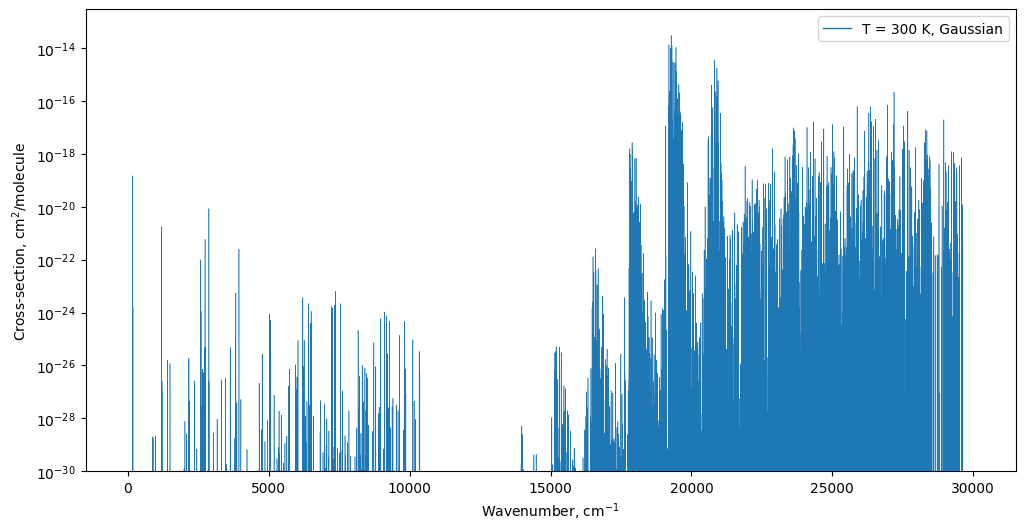

Cross sections plot saved.
Cross sections file saved.
Running time on CPU       : 73.999843516 s
Running time on system    : 15.91807246208191 s

The program total running time:
Running time on CPU       : 74.02229548300001 s
Running time on system    : 15.940110445022583 s

Finished!


In [62]:
get_results(read_path)

# Test and plot

In [63]:
database = 'ExoMol'
states_df = read_all_states(read_path)
states_part_df = read_part_states(states_df)
trans_part_df = read_part_trans(read_path)
broad,ratio,default_broad_df,air_broad_df,self_broad_df,H2_broad_df,He_broad_df = read_broad(read_path)
A, v, Epp, gp, gamma_L, n_air = linelist_exomol_abs(broad,ratio,cutoff,states_part_df,trans_part_df,default_broad_df,
                                                    air_broad_df,self_broad_df,H2_broad_df,He_broad_df)

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


Broadeners 	:  Default 	 Air 	 Self 	 H2 	 He
Ratios 		:  1.0 		 0.0 	 0.0 	 0.0 	 0.0


In [64]:
P = 0.1
Ts = [300, 3000]
profile = 'Gaussian'
wn = []
xsec = []
for i in range(len(Ts)):
    T = Ts[i]
    Q = read_exomol_pf(read_path, T)
    coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
    alpha = Doppler_HWHM(v)
    alpha = np.full(len(alpha), 3)
    sigma = Gaussian_standard_deviation(alpha)
    '''
    gamma = pd.DataFrame()
    for i in range(len(broad)):
        gamma[i] = Lorentzian_HWHM (gamma_L[i].values, n_air[i].values)
    gamma = gamma.sum(axis=1).values
    '''
    wn_xsec = pd.DataFrame()
    wn_xsec['v'] = wn_grid
    wn_xsec['xsec'] = cross_section_Gaussian(wn_grid, v, sigma, coef, cutoff, threshold)
    #wn_xsec['xsec'] = cross_section_SciPyVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)
    wns = list(wn_xsec['v'])
    xsecs = list(wn_xsec['xsec'])
    
    wn.append(wns)
    xsec.append(xsecs)



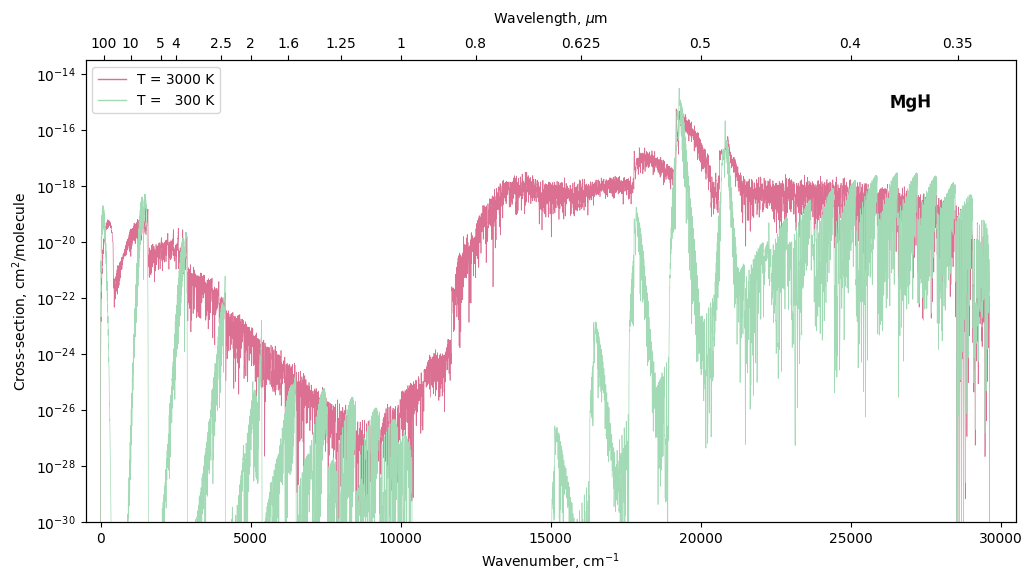

Cross sections plot saved.


In [65]:
fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(wn[4], xsec[4], label='T = '+str(Ts[4])+' K', linewidth=0.4, color="yellowgreen")
#ax.plot(wn[3], xsec[3], label='T = '+str(Ts[3])+' K', linewidth=0.4, color="orange")
#ax.plot(wn[2], xsec[2], label='T = '+str(Ts[2])+' K', linewidth=0.4, color="#41b6c4")
ax.plot(wn[1], xsec[1], label='T = '+str(Ts[1])+' K', linewidth=0.5, color="palevioletred")
ax.plot(wn[0], xsec[0], label='T =   '+str(Ts[0])+' K', linewidth=0.5, color="#a1dab4")

#ax.plot(wn[5], xsec[5], label='T = '+str(Ts[0])+' K', linewidth=0.5, color="salmon")


ax_top=ax.twiny() 
xticks = ax.get_xticks()
ax.set_xticks(xticks)

ax.set_xlim(min_wn-500, max_wn+500)
ax.set_ylim([1e-30, 10*max(max(xsec[i]) for i in range(len(Ts)))])

xlim = ax.get_xlim()
ax_top.set_xlim(xlim)
# The values (labels) of the top x-axis.
top_label = [100, 10, 5, 4, 2.5, 2, 1.6, 1.25, 1, 0.8, 0.625, 0.5, 0.4, int((10000/max_wn)*10)/10+0.05]  
# The corresponding positions of the top x-axis.    
top_tick = list(10000/np.array(top_label))                       
ax_top.set_xticks(top_tick)
ax_top.set_xticklabels(top_label)
ax_top.set_xlabel('Wavelength, $\mu$m', labelpad=10)

ax.semilogy()
ax.set_xlabel('Wavenumber, cm$^{-1}$')
ax.set_ylabel('Cross-section, cm$^{2}$/molecule')

# Get the legend object
leg = ax.legend(loc=2)
# Change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(1.0)

plt.text(x=27000, y=1e-15, s=molecule, rotation=1, ha='center', va='center',
         fontdict=dict(fontsize=12, color='black', family='sans-serif', weight='black'))

plots_foldername = save_path+'/xsecs/plots/'+molecule+'/'+database+'/'
if os.path.exists(plots_foldername):
    pass
else:
    os.makedirs(plots_foldername, exist_ok=True) 
str_T = str(Ts).replace(', ','_').replace('[','').replace(']','')
plt.savefig(plots_foldername+molecule+'__T'+str_T+'__'+wn_wl+str(min_wn)+'-'+str(max_wn)+'__'
            +database+'__'+abs_emi+'__'+profile+'.png', dpi=500)
plt.show()
print('Cross sections plot saved.')

In [66]:
'''
database = 'ExoMol'
T = 300
states_df = read_all_states(read_path)
states_part_df = read_part_states(states_df)
trans_part_df = read_part_trans(read_path)
broad,ratio,default_broad_df,air_broad_df,self_broad_df,H2_broad_df,He_broad_df = read_broad(read_path)
Q = read_exomolweb_pf(T)
A, v, Epp, gp, gamma_L, n_air = linelist_exomol_abs(broad,ratio,cutoff,states_part_df,trans_part_df,default_broad_df,
                                                    air_broad_df,self_broad_df,H2_broad_df,He_broad_df)
coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)

alpha = Doppler_HWHM(v)
sigma = Gaussian_standard_deviation(alpha)
gamma = pd.DataFrame()
for i in range(len(broad)):
    gamma[i] = Lorentzian_HWHM (gamma_L[i].values, n_air[i].values)
gamma = gamma.sum(axis=1).values
'''


"\ndatabase = 'ExoMol'\nT = 300\nstates_df = read_all_states(read_path)\nstates_part_df = read_part_states(states_df)\ntrans_part_df = read_part_trans(read_path)\nbroad,ratio,default_broad_df,air_broad_df,self_broad_df,H2_broad_df,He_broad_df = read_broad(read_path)\nQ = read_exomolweb_pf(T)\nA, v, Epp, gp, gamma_L, n_air = linelist_exomol_abs(broad,ratio,cutoff,states_part_df,trans_part_df,default_broad_df,\n                                                    air_broad_df,self_broad_df,H2_broad_df,He_broad_df)\ncoef = cal_abscoefs(v, gp, A, Epp, Q, abundance)\n\nalpha = Doppler_HWHM(v)\nsigma = Gaussian_standard_deviation(alpha)\ngamma = pd.DataFrame()\nfor i in range(len(broad)):\n    gamma[i] = Lorentzian_HWHM (gamma_L[i].values, n_air[i].values)\ngamma = gamma.sum(axis=1).values\n"

In [67]:
'''
xsec1 = cross_section_Doppler(wn_grid, v, alpha, coef, cutoff, threshold)
xsec2 = cross_section_Gaussian(wn_grid, v, sigma, coef, cutoff, threshold)
xsec3 = cross_section_Lorentzian(wn_grid, v, gamma, coef, cutoff, threshold)
xsec4 = cross_section_SciPyVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)
xsec5 = cross_section_SciPyWofzVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)
xsec6 = cross_section_PseudoVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold) 
xsec7 = cross_section_PseudoApproxVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)
'''

'\nxsec1 = cross_section_Doppler(wn_grid, v, alpha, coef, cutoff, threshold)\nxsec2 = cross_section_Gaussian(wn_grid, v, sigma, coef, cutoff, threshold)\nxsec3 = cross_section_Lorentzian(wn_grid, v, gamma, coef, cutoff, threshold)\nxsec4 = cross_section_SciPyVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)\nxsec5 = cross_section_SciPyWofzVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)\nxsec6 = cross_section_PseudoVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold) \nxsec7 = cross_section_PseudoApproxVoigt(wn_grid, v, sigma, gamma, coef, cutoff, threshold)\n'

In [68]:
'''
plot_xsec(wn_grid, xsec1, database, profile)
plot_xsec(wn_grid, xsec2, database, profile)
plot_xsec(wn_grid, xsec3, database, profile)
plot_xsec(wn_grid, xsec4, database, profile)
plot_xsec(wn_grid, xsec5, database, profile)
plot_xsec(wn_grid, xsec6, database, profile)
plot_xsec(wn_grid, xsec7, database, profile)
'''


'\nplot_xsec(wn_grid, xsec1, database, profile)\nplot_xsec(wn_grid, xsec2, database, profile)\nplot_xsec(wn_grid, xsec3, database, profile)\nplot_xsec(wn_grid, xsec4, database, profile)\nplot_xsec(wn_grid, xsec5, database, profile)\nplot_xsec(wn_grid, xsec6, database, profile)\nplot_xsec(wn_grid, xsec7, database, profile)\n'

## Plot partition function

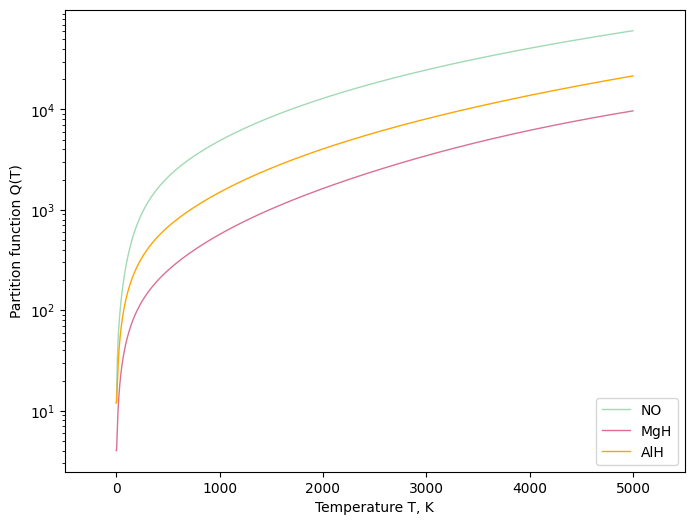

In [69]:
mol = ['NO', 'MgH', 'AlH']
iso = ['14N-16O', '24Mg-1H', '27Al-1H']
dst = ['XABC', 'XAB', 'AlHambra']
T = []
Q = []
for i in range(len(iso)):
    read_partition = pd.read_csv(save_path+'partition/'+iso[i]+'__'+dst[i]+'.pf', sep='\\s+', names=['T', 'Q'])
    T_Q = pd.DataFrame()
    T_Q['T'] = read_partition['T']
    T_Q['Q'] = read_partition['Q']
    Ts = list(T_Q['T'])
    Qs = list(T_Q['Q'])
    T.append(Ts)
    Q.append(Qs)
    
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T[0], Q[0], label='NO', linewidth=1, color="#a1dab4")
ax.plot(T[1], Q[1], label='MgH', linewidth=1, color="palevioletred")
ax.plot(T[2], Q[2], label='AlH', linewidth=1, color="orange")
ax.set_xlim(min(T[0])-500, max(max(T[i]) for i in range(len(iso)))+500)
xmajorLocator   = MultipleLocator(1000)
ax.xaxis.set_major_locator(xmajorLocator)
leg = ax.legend(loc=4)
for line in leg.get_lines():
    line.set_linewidth(1.0)
ax.semilogy()
plt.xlabel('Temperature T, K')
plt.ylabel('Partition function Q(T)')
plt.show()

## Plot specific heat

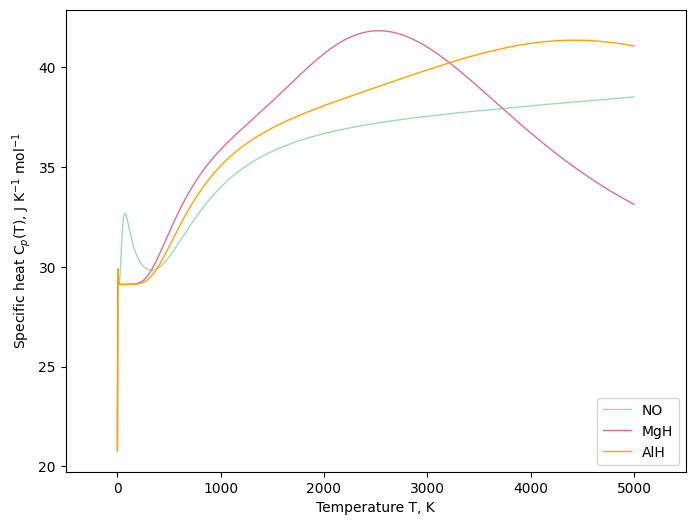

In [70]:
mol = ['NO', 'MgH', 'AlH']
iso = ['14N-16O', '24Mg-1H', '27Al-1H']
dst = ['XABC', 'XAB', 'AlHambra']
T = []
C = []
for i in range(len(iso)):
    read_specificheat = pd.read_csv(save_path+'specific_heat/'+iso[i]+'__'+dst[i]+'.cp', sep='\\s+', names=['T', 'C'])
    T_C = pd.DataFrame()
    T_C['T'] = read_specificheat['T']
    T_C['C'] = read_specificheat['C']
    Ts = list(T_C['T'])
    Cs = list(T_C['C'])
    T.append(Ts)
    C.append(Cs)
    
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T[0], C[0], label='NO', linewidth=1, color="#a1dab4")
ax.plot(T[1], C[1], label='MgH', linewidth=1, color="palevioletred")
ax.plot(T[2], C[2], label='AlH', linewidth=1, color="orange")
ax.set_xlim(min(T[0])-500, max(max(T[i]) for i in range(len(iso)))+500)
xmajorLocator   = MultipleLocator(1000)
ax.xaxis.set_major_locator(xmajorLocator)
leg = ax.legend(loc=4)
for line in leg.get_lines():
    line.set_linewidth(1.0)
plt.xlabel('Temperature T, K')
plt.ylabel('Specific heat C$_p$(T), J K$^{-1}$ mol$^{-1}$')
plt.show()

## Plot cooling function

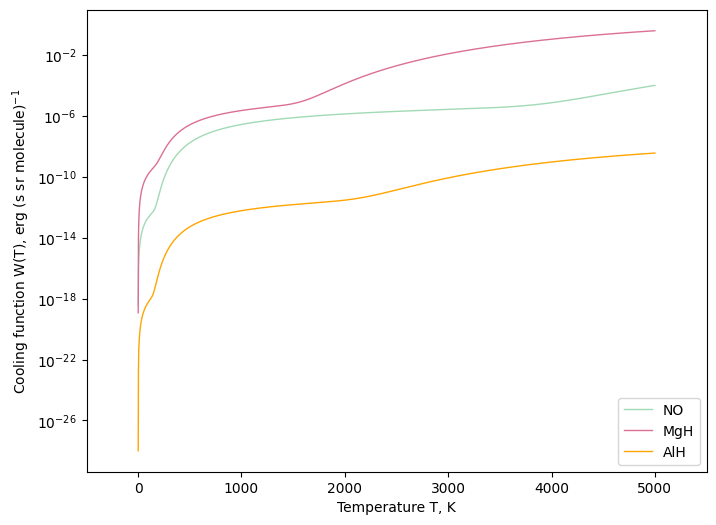

In [71]:
mol = ['NO', 'MgH', 'AlH']
iso = ['14N-16O', '24Mg-1H', '27Al-1H']
dst = ['XABC', 'XAB', 'AlHambra']
T = []
W = []
for i in range(len(iso)):
    read_cooling = pd.read_csv(save_path+'cooling/'+iso[i]+'__'+dst[i]+'.cooling', sep='\\s+', names=['T', 'W'])
    T_W = pd.DataFrame()
    T_W['T'] = read_cooling['T']
    T_W['W'] = read_cooling['W']
    Ts = list(T_W['T'])
    Ws = list(T_W['W'])
    T.append(Ts)
    W.append(Ws)
    
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(T[0], W[0], label='NO', linewidth=1, color="#a1dab4")
ax.plot(T[1], W[1], label='MgH', linewidth=1, color="palevioletred")
ax.plot(T[2], W[2], label='AlH', linewidth=1, color="orange")
ax.set_xlim(min(T[0])-500, max(max(T[i]) for i in range(len(iso)))+500)
xmajorLocator   = MultipleLocator(1000)
ax.xaxis.set_major_locator(xmajorLocator)
leg = ax.legend(loc=4)
for line in leg.get_lines():
    line.set_linewidth(1.0)
ax.semilogy()
plt.xlabel('Temperature T, K')
plt.ylabel('Cooling function W(T), erg (s sr molecule)${}^{-1}$')
plt.show()

## Plot lifetime

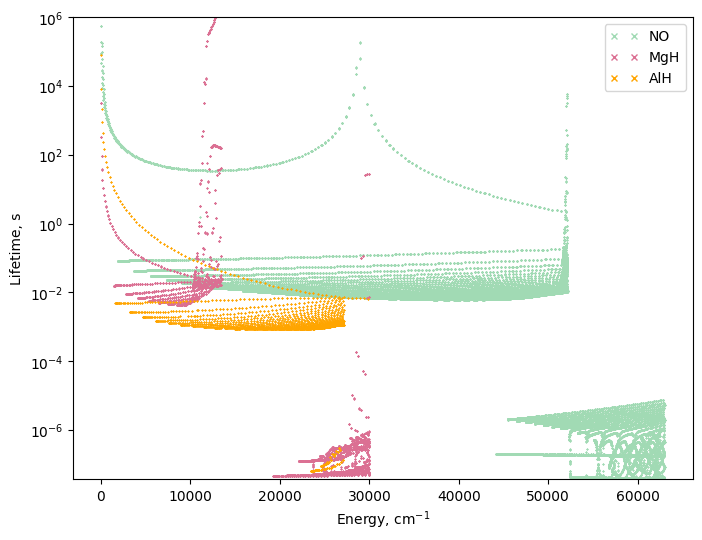

In [72]:
mol = ['NO', 'MgH', 'AlH']
iso = ['14N-16O', '24Mg-1H', '27Al-1H']
dst = ['XABC', 'XAB', 'AlHambra']
E = []
tau = []
for i in range(len(iso)):
    read_lifetime = pd.read_csv(save_path+'lifetime/'+iso[i]+'__'+dst[i]+'.states', sep='\\s+', names=['id','E','g','J','unc','tau'], usecols=[0,1,2,3,4,5])
    E_tau = pd.DataFrame()
    E_tau['E'] = read_lifetime['E']
    E_tau['tau'] = read_lifetime['tau']
    Es = list(E_tau['E'])
    taus = list(E_tau['tau'])
    E.append(Es)
    tau.append(taus)
    
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(E[0], tau[0], 'x', label='NO', markersize=1, color="#a1dab4")
ax.plot(E[1], tau[1], 'x', label='MgH', markersize=1, color="palevioletred")
ax.plot(E[2], tau[2], 'x', label='AlH', markersize=1, color="orange")
ax.semilogy()
ax.set_ylim(min(min(tau[i]) for i in range(len(iso))), 1e6)
ax.legend(loc="best", markerscale=5, numpoints=2, scatterpoints=1, fontsize=10)

plt.xlabel('Energy, cm$^{-1}$')
plt.ylabel('Lifetime, s')
plt.show()

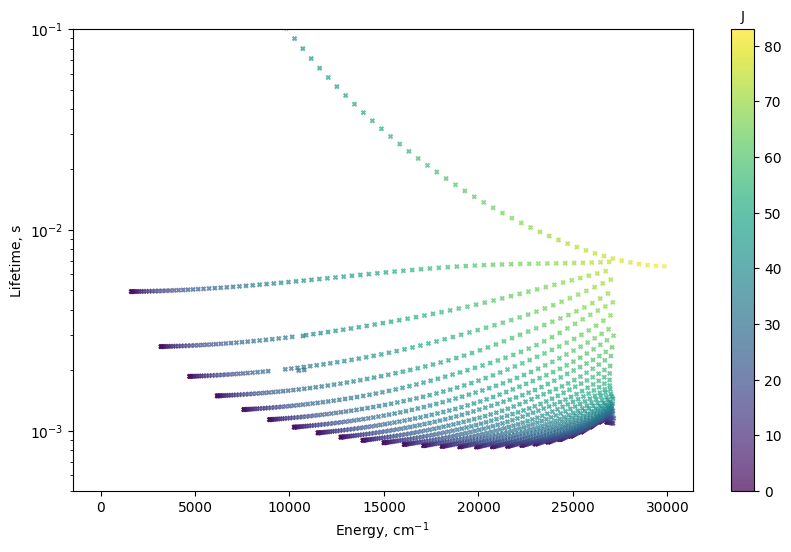

In [117]:
mol = ['AlH']
iso = ['27Al-1H']
dst = ['AlHambra']

read_lifetime = pd.read_csv(save_path+'lifetime/'+iso[0]+'__'+dst[0]+'.states', sep='\\s+', names=['id','E','g','J','unc','tau'], usecols=[0,1,2,3,4,5])
E = read_lifetime['E']
tau = read_lifetime['tau']
J = read_lifetime['J']

plt.figure(figsize=(10, 6))
plt.scatter(E, tau, marker='x', s=8, facecolors='none', c=J, cmap='viridis', alpha=0.7)
plt.ylim(5*1e-4, 1e-1)
#plt.legend(loc="best", markerscale=2., numpoints=2, scatterpoints=1, fontsize=12)
plt.semilogy()

plt.xlabel('Energy, cm$^{-1}$')
plt.ylabel('Lifetime, s')
#plt.colorbar()
clb=plt.colorbar()
clb.ax.tick_params(labelsize=10) 
clb.ax.set_title('J',fontsize=10)
plt.show()